🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃
   ENHANCED TEA QUALITY DETECTION SYSTEM
🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃🍃

🔄 PHASE 1: DATA LOADING & ANALYSIS

📊 DATASET OVERVIEW

📋 Dataset Distribution Table:
------------------------------------------------------------
Split           Test  Train  Valid
Class                             
Basic Grade      215    747    106
Premium Grade    215    747    106
Reject Grade     215    747    106
Standard Grade   215    747    106

📈 Summary Statistics:
Total Samples: 4272
Train Set: 2988 samples (69.9%)
Valid Set: 424 samples (9.9%)
Test Set: 860 samples (20.1%)


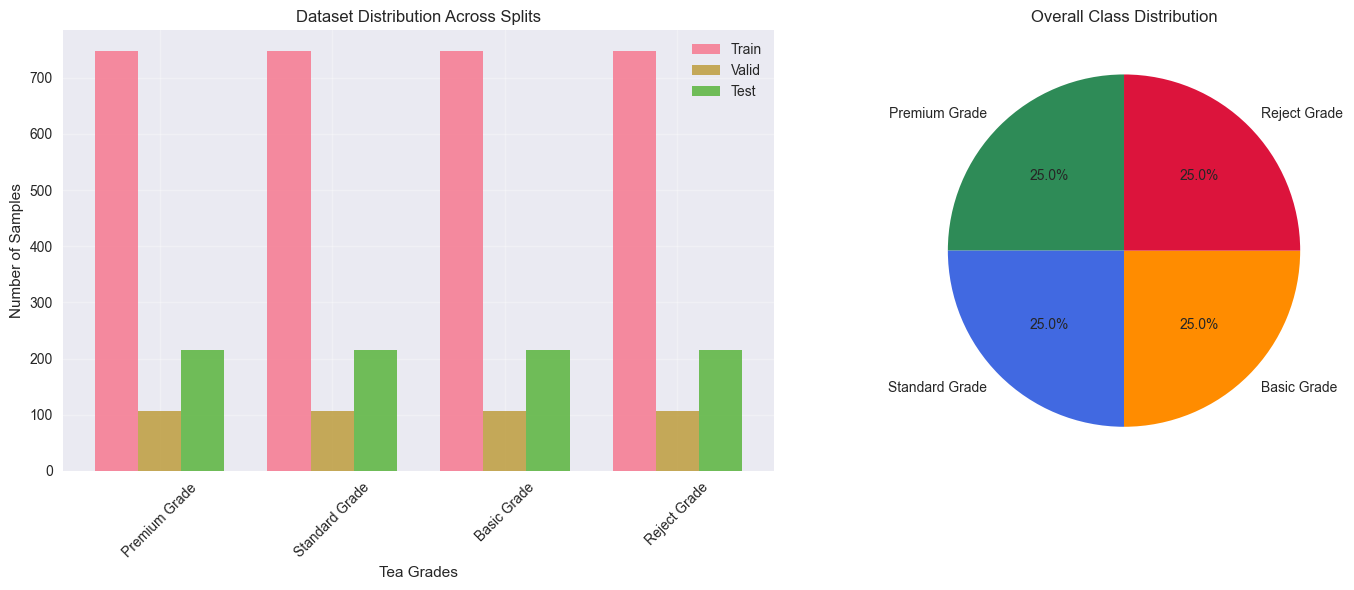


📥 Loading training data...
📥 Loading validation data...
📥 Loading test data...

✅ Data Loading Complete:
  • Training: 2988 samples
  • Validation: 424 samples
  • Test: 860 samples

📸 Training Samples
------------------------------------------------------------


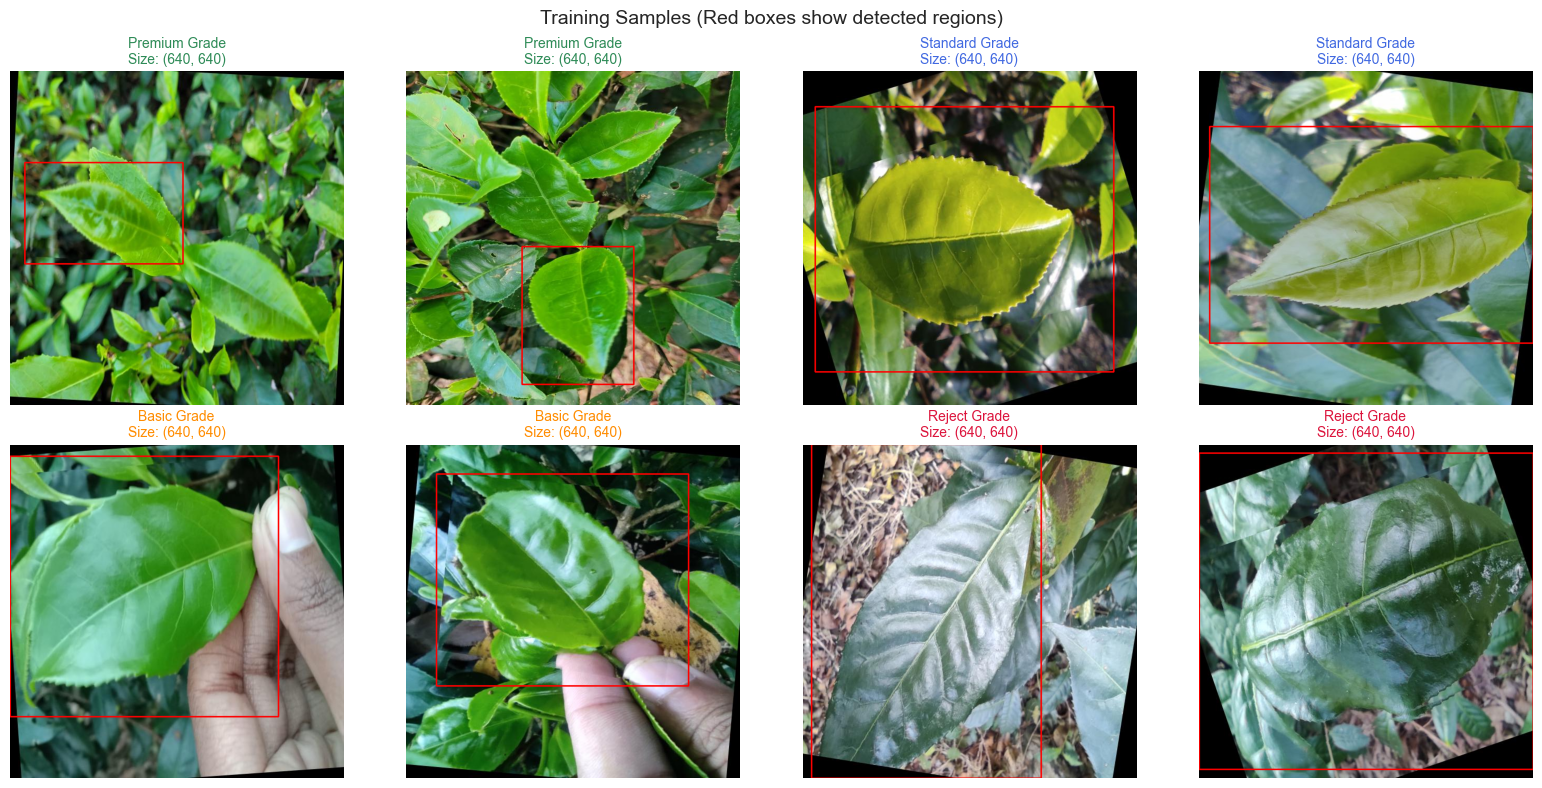


🔄 PHASE 2: DATA PREPROCESSING
🔧 Extracting ROI from training data...
🔧 Extracting ROI from validation data...
🔧 Extracting ROI from test data...

🔧 Preprocessed Training ROI
------------------------------------------------------------


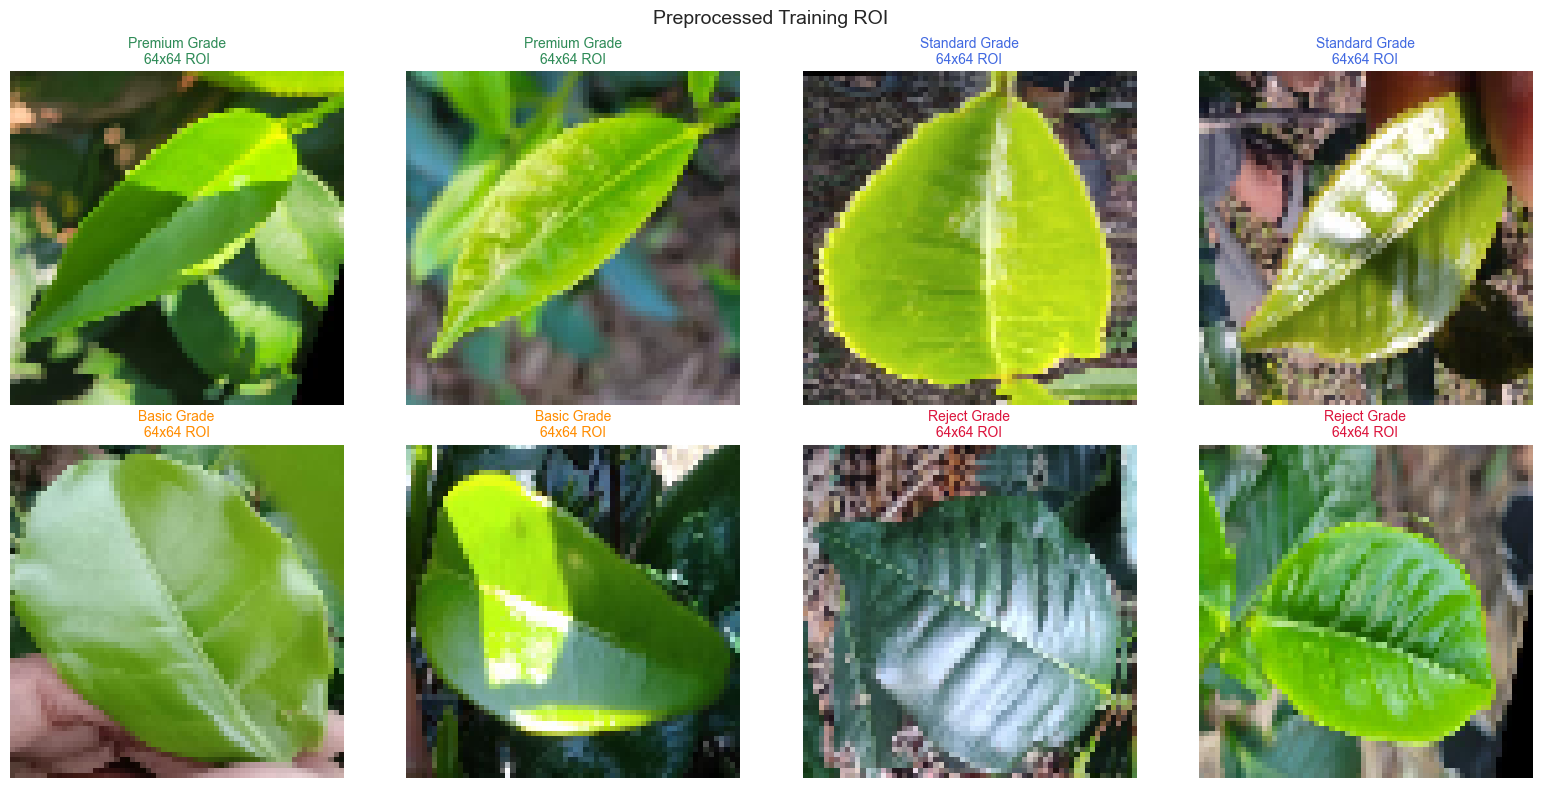


✅ Preprocessing Complete:
  • Training ROI: (2988, 64, 64, 3)
  • Validation ROI: (424, 64, 64, 3)
  • Test ROI: (860, 64, 64, 3)

🔄 PHASE 3: FEATURE EXTRACTION
🔍 Extracting features from training data...
🎯 Fitting PCA on training features...

🔍 FEATURE EXTRACTION DETAILS
------------------------------------------------------------
📊 Feature Dimensions:
  • Color Histogram Features: 288
  • Gabor Texture Features: 432
  • HOG Shape Features: 1764
  • Total Original Features: 2484

🎯 PCA Information:
  • Components Retained: 554
  • Explained Variance Ratio: 0.9500
  • Dimension Reduction: 2484 → 554


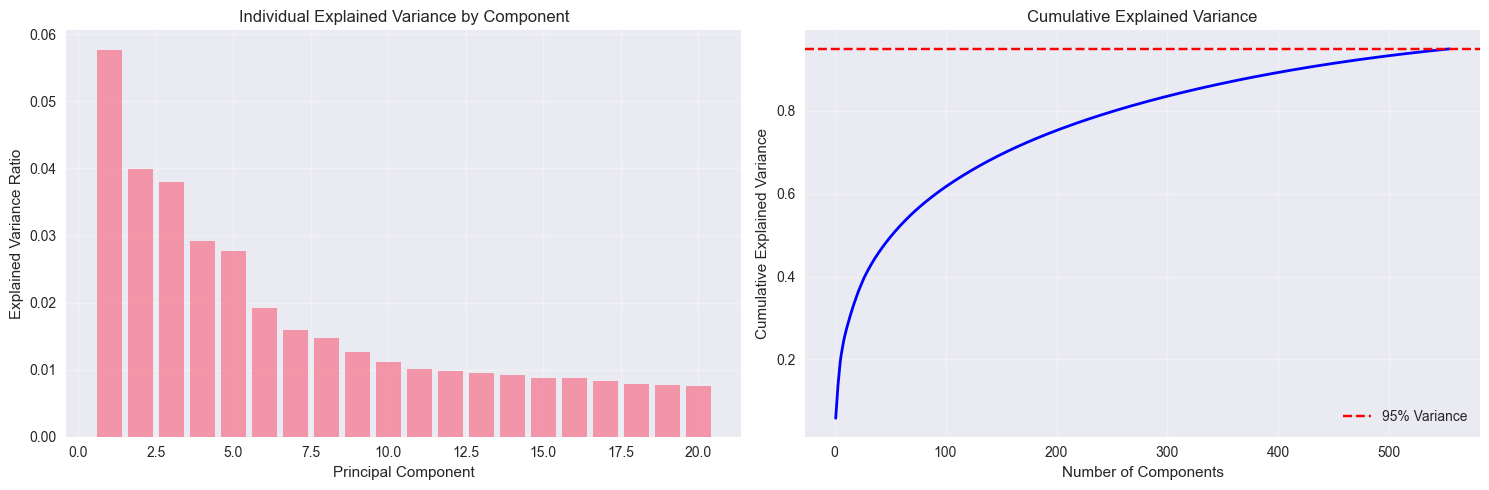

🔧 Applying PCA transformation...
🔍 Extracting features from validation data...
🔍 Extracting features from test data...

✅ Feature Extraction Complete:
  • Training features: (2988, 554)
  • Validation features: (424, 554)
  • Test features: (860, 554)

🔄 PHASE 4: MODEL TRAINING

🎯 SVM PARAMETER OPTIMIZATION
------------------------------------------------------------
📊 Training Data Distribution:
  • Class 0: 747 samples (25.0%)
  • Class 1: 747 samples (25.0%)
  • Class 2: 747 samples (25.0%)
  • Class 3: 747 samples (25.0%)

🔍 Grid Search Configuration:
  • Cross-validation folds: 5
  • Scoring metric: F1 Macro
❌ Error during analysis: cannot access free variable 'ParameterGrid' where it is not associated with a value in enclosing scope


In [ ]:
# ========================================
# ENHANCED TEA QUALITY DETECTION SYSTEM
# ========================================

import cv2
import numpy as np
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, ParameterGrid
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import glob
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ========================================
# PHASE 1: ENHANCED DATASET LOADING
# ========================================

class YOLODataLoader:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.class_names = {
            0: 'Premium Grade',
            1: 'Standard Grade', 
            2: 'Basic Grade',
            3: 'Reject Grade'
        }
        self.class_colors = {
            0: '#2E8B57',  # SeaGreen
            1: '#4169E1',  # RoyalBlue
            2: '#FF8C00',  # DarkOrange
            3: '#DC143C'   # Crimson
        }
    
    def load_yolo_data(self, subset='train'):
        """Load YOLO format dataset with better error handling"""
        images_path = os.path.join(self.dataset_path, subset, 'images')
        labels_path = os.path.join(self.dataset_path, subset, 'labels')
        
        images = []
        labels = []
        bboxes = []
        
        # Get all image files
        image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
        image_files = []
        for ext in image_extensions:
            image_files.extend(glob.glob(os.path.join(images_path, ext)))
        
        for img_file in image_files:
            try:
                # Load image
                img = cv2.imread(img_file)
                if img is None:
                    continue
                    
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # Get corresponding label file
                base_name = os.path.splitext(os.path.basename(img_file))[0]
                label_file = os.path.join(labels_path, base_name + '.txt')
                
                if os.path.exists(label_file):
                    with open(label_file, 'r') as f:
                        line = f.readline().strip()
                        if line:
                            parts = line.split()
                            class_id = int(parts[0])
                            x_center = float(parts[1])
                            y_center = float(parts[2])
                            width = float(parts[3])
                            height = float(parts[4])
                            
                            images.append(img)
                            labels.append(class_id)
                            bboxes.append([x_center, y_center, width, height])
            except Exception as e:
                print(f"Error loading {img_file}: {e}")
                continue
        
        return np.array(images), np.array(labels), np.array(bboxes)
    
    def extract_roi(self, image, bbox):
        """Extract Region of Interest with improved sizing"""
        h, w = image.shape[:2]
        
        # Convert YOLO format to pixel coordinates
        x_center, y_center, width, height = bbox
        x_center *= w
        y_center *= h
        width *= w
        height *= h
        
        # Calculate bounding box coordinates
        x1 = int(x_center - width/2)
        y1 = int(y_center - height/2)
        x2 = int(x_center + width/2)
        y2 = int(y_center + height/2)
        
        # Ensure coordinates are within image bounds
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(w, x2)
        y2 = min(h, y2)
        
        roi = image[y1:y2, x1:x2]
        
        # Resize ROI to larger standard size for better feature extraction
        if roi.size > 0:
            roi = cv2.resize(roi, (64, 64))
        else:
            roi = np.zeros((64, 64, 3), dtype=np.uint8)
            
        return roi
    
    def get_dataset_statistics(self):
        """Get comprehensive dataset statistics"""
        stats = {'train': {}, 'valid': {}, 'test': {}}
        
        for subset in ['train', 'valid', 'test']:
            try:
                _, labels, _ = self.load_yolo_data(subset)
                label_counts = Counter(labels)
                
                stats[subset]['total'] = len(labels)
                stats[subset]['class_counts'] = {
                    self.class_names[k]: v for k, v in label_counts.items()
                }
                
                # Add percentage
                total = len(labels)
                stats[subset]['class_percentages'] = {
                    self.class_names[k]: (v/total)*100 for k, v in label_counts.items()
                }
            except Exception as e:
                print(f"Error getting stats for {subset}: {e}")
                stats[subset] = {'total': 0, 'class_counts': {}, 'class_percentages': {}}
        
        return stats

# ========================================
# PHASE 2: ENHANCED VISUALIZATION
# ========================================

class DataVisualizer:
    def __init__(self, data_loader):
        self.data_loader = data_loader
    
    def display_dataset_overview(self, stats):
        """Display comprehensive dataset overview"""
        print("\n" + "="*80)
        print("📊 DATASET OVERVIEW")
        print("="*80)
        
        # Create DataFrame for better visualization
        df_data = []
        for subset in ['train', 'valid', 'test']:
            for class_name, count in stats[subset]['class_counts'].items():
                percentage = stats[subset]['class_percentages'][class_name]
                df_data.append({
                    'Split': subset.title(),
                    'Class': class_name,
                    'Count': count,
                    'Percentage': f"{percentage:.1f}%"
                })
        
        df = pd.DataFrame(df_data)
        
        # Display table
        print("\n📋 Dataset Distribution Table:")
        print("-" * 60)
        pivot_table = df.pivot(index='Class', columns='Split', values='Count').fillna(0)
        print(pivot_table.to_string())
        
        # Summary statistics
        total_samples = sum(stats[subset]['total'] for subset in stats.keys())
        print(f"\n📈 Summary Statistics:")
        print(f"Total Samples: {total_samples}")
        for subset in ['train', 'valid', 'test']:
            total = stats[subset]['total']
            percentage = (total/total_samples)*100 if total_samples > 0 else 0
            print(f"{subset.title()} Set: {total} samples ({percentage:.1f}%)")
        
        # Plot distribution
        self._plot_class_distribution(stats)
        
        return df
    
    def _plot_class_distribution(self, stats):
        """Plot class distribution across splits"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot 1: Bar chart showing distribution across splits
        splits = ['train', 'valid', 'test']
        class_names = list(self.data_loader.class_names.values())
        
        x = np.arange(len(class_names))
        width = 0.25
        
        for i, split in enumerate(splits):
            counts = [stats[split]['class_counts'].get(class_name, 0) for class_name in class_names]
            axes[0].bar(x + i*width, counts, width, label=split.title(), alpha=0.8)
        
        axes[0].set_xlabel('Tea Grades')
        axes[0].set_ylabel('Number of Samples')
        axes[0].set_title('Dataset Distribution Across Splits')
        axes[0].set_xticks(x + width)
        axes[0].set_xticklabels(class_names, rotation=45)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Pie chart for total distribution
        total_counts = {}
        for class_name in class_names:
            total_counts[class_name] = sum(
                stats[split]['class_counts'].get(class_name, 0) for split in splits
            )
        
        colors = [self.data_loader.class_colors[i] for i in range(len(class_names))]
        wedges, texts, autotexts = axes[1].pie(
            total_counts.values(), 
            labels=total_counts.keys(),
            autopct='%1.1f%%',
            colors=colors,
            startangle=90
        )
        axes[1].set_title('Overall Class Distribution')
        
        plt.tight_layout()
        plt.show()
    
    def display_original_samples(self, X_raw, y_labels, bboxes, title="Original Images", samples_per_class=2):
        """Display original images before preprocessing"""
        print(f"\n📸 {title}")
        print("-" * 60)
        
        # Get samples for each class
        unique_classes = np.unique(y_labels)
        total_samples = len(unique_classes) * samples_per_class
        
        # Calculate grid size
        cols = 4
        rows = (total_samples + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
        if rows == 1:
            axes = axes.reshape(1, -1)
        
        sample_idx = 0
        for class_id in unique_classes:
            class_indices = np.where(y_labels == class_id)[0]
            selected_indices = np.random.choice(
                class_indices, 
                min(samples_per_class, len(class_indices)), 
                replace=False
            )
            
            for idx in selected_indices:
                if sample_idx >= total_samples:
                    break
                    
                row = sample_idx // cols
                col = sample_idx % cols
                
                # Display original image with bounding box
                img = X_raw[idx].copy()
                bbox = bboxes[idx]
                
                # Draw bounding box
                h, w = img.shape[:2]
                x_center, y_center, width, height = bbox
                x_center *= w
                y_center *= h
                width *= w
                height *= h
                
                x1 = int(x_center - width/2)
                y1 = int(y_center - height/2)
                x2 = int(x_center + width/2)
                y2 = int(y_center + height/2)
                
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                
                axes[row, col].imshow(img)
                axes[row, col].set_title(
                    f'{self.data_loader.class_names[class_id]}\nSize: {img.shape[:2]}',
                    fontsize=10,
                    color=self.data_loader.class_colors[class_id]
                )
                axes[row, col].axis('off')
                sample_idx += 1
        
        # Hide unused subplots
        for i in range(sample_idx, rows * cols):
            row = i // cols
            col = i % cols
            axes[row, col].axis('off')
        
        plt.suptitle(f'{title} (Red boxes show detected regions)', fontsize=14)
        plt.tight_layout()
        plt.show()
    
    def display_preprocessed_samples(self, X_roi, y_labels, title="Preprocessed ROI Images", samples_per_class=2):
        """Display preprocessed ROI images"""
        print(f"\n🔧 {title}")
        print("-" * 60)
        
        # Get samples for each class
        unique_classes = np.unique(y_labels)
        total_samples = len(unique_classes) * samples_per_class
        
        # Calculate grid size
        cols = 4
        rows = (total_samples + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
        if rows == 1:
            axes = axes.reshape(1, -1)
        
        sample_idx = 0
        for class_id in unique_classes:
            class_indices = np.where(y_labels == class_id)[0]
            selected_indices = np.random.choice(
                class_indices, 
                min(samples_per_class, len(class_indices)), 
                replace=False
            )
            
            for idx in selected_indices:
                if sample_idx >= total_samples:
                    break
                    
                row = sample_idx // cols
                col = sample_idx % cols
                
                roi = X_roi[idx]
                axes[row, col].imshow(roi)
                axes[row, col].set_title(
                    f'{self.data_loader.class_names[class_id]}\n64x64 ROI',
                    fontsize=10,
                    color=self.data_loader.class_colors[class_id]
                )
                axes[row, col].axis('off')
                sample_idx += 1
        
        # Hide unused subplots
        for i in range(sample_idx, rows * cols):
            row = i // cols
            col = i % cols
            axes[row, col].axis('off')
        
        plt.suptitle(title, fontsize=14)
        plt.tight_layout()
        plt.show()

# ========================================
# PHASE 3: ENHANCED FEATURE EXTRACTION
# ========================================

class FCGHOGExtractor:
    def __init__(self, pca_components=0.95):
        # Optimized HOG parameters for 64x64 images
        self.orientations = 9
        self.pixels_per_cell = (8, 8)
        self.cells_per_block = (2, 2)
        self.color_bins = 32
        
        # Gabor parameters
        self.ksize = 21
        self.sigma = 2.0
        self.gamma = 0.5
        self.phi = 0
        self.scales = [4, 8, 16]
        self.orientations_gabor = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        
        self.pca_components = pca_components
        self.pca = None
        self.scaler = StandardScaler()
        self.is_fitted = False
        
        # Feature dimensions tracking
        self.feature_dims = {}
    
    def create_gabor_kernels(self):
        """Create Gabor kernels with improved parameters"""
        kernels = []
        for scale in self.scales:
            for orientation in self.orientations_gabor:
                kernel = cv2.getGaborKernel(
                    (self.ksize, self.ksize), self.sigma, orientation, scale, self.gamma, self.phi, ktype=cv2.CV_32F
                )
                kernels.append(kernel)
        return kernels
    
    def extract_gabor_features(self, image):
        """Extract Gabor features with improved processing"""
        try:
            hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        except:
            hsv = image.copy()
            lab = image.copy()
        
        color_spaces = [image, hsv, lab]
        gabor_kernels = self.create_gabor_kernels()
        gabor_features = []
        
        for color_img in color_spaces:
            for channel in range(3):
                channel_data = color_img[:, :, channel].astype(np.float32)
                
                for kernel in gabor_kernels:
                    try:
                        filtered = cv2.filter2D(channel_data, cv2.CV_32F, kernel)
                        mean_val = np.mean(filtered)
                        std_val = np.std(filtered)
                        max_val = np.max(filtered)
                        min_val = np.min(filtered)
                        
                        gabor_features.extend([mean_val, std_val, max_val, min_val])
                    except:
                        gabor_features.extend([0.0, 0.0, 0.0, 0.0])
        
        return np.array(gabor_features)
    
    def extract_hog_features(self, image):
        """Extract HOG features with better error handling"""
        try:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        except:
            gray = image[:,:,0] if len(image.shape) == 3 else image
        
        if gray.shape[0] < 16 or gray.shape[1] < 16:
            gray = cv2.resize(gray, (64, 64))
        
        try:
            hog_features = hog(
                gray,
                orientations=self.orientations,
                pixels_per_cell=self.pixels_per_cell,
                cells_per_block=self.cells_per_block,
                block_norm='L2-Hys',
                visualize=False,
                feature_vector=True,
                transform_sqrt=True
            )
            return hog_features
        except Exception as e:
            print(f"HOG Error: {e}")
            return np.zeros(324)
    
    def extract_color_histogram(self, image):
        """Extract improved color histograms"""
        try:
            hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        except:
            hsv = image.copy()
            lab = image.copy()
        
        color_spaces = [image, hsv, lab]
        hist_features = []
        
        for color_img in color_spaces:
            for channel in range(3):
                try:
                    hist = cv2.calcHist([color_img], [channel], None, [self.color_bins], [0, 256])
                    hist = cv2.normalize(hist, hist, norm_type=cv2.NORM_L2).flatten()
                    hist_features.extend(hist)
                except:
                    hist_features.extend(np.zeros(self.color_bins))
        
        return np.array(hist_features)
    
    def extract_features(self, image, apply_pca=False):
        """Extract complete FCGHOG features with tracking"""
        try:
            # Extract individual feature types
            color_features = self.extract_color_histogram(image)
            gabor_features = self.extract_gabor_features(image)
            hog_features = self.extract_hog_features(image)
            
            # Store dimensions for reporting
            if not hasattr(self, '_dims_recorded'):
                self.feature_dims = {
                    'color': len(color_features),
                    'gabor': len(gabor_features),
                    'hog': len(hog_features)
                }
                self._dims_recorded = True
            
            # Combine features
            combined_features = np.concatenate([color_features, gabor_features, hog_features])
            combined_features = np.nan_to_num(combined_features, nan=0.0, posinf=1.0, neginf=-1.0)
            
            if apply_pca and self.pca is not None and self.is_fitted:
                combined_features = combined_features.reshape(1, -1)
                combined_features = self.scaler.transform(combined_features)
                combined_features = self.pca.transform(combined_features)
                return combined_features.flatten()
            
            return combined_features
        
        except Exception as e:
            print(f"Feature extraction error: {e}")
            return np.zeros(1000)
    
    def fit_pca(self, feature_matrix):
        """Fit PCA and Scaler with detailed reporting"""
        try:
            feature_matrix = np.nan_to_num(feature_matrix, nan=0.0, posinf=1.0, neginf=-1.0)
            
            # Standardize features
            feature_matrix_scaled = self.scaler.fit_transform(feature_matrix)
            
            # Fit PCA
            self.pca = PCA(n_components=self.pca_components)
            self.pca.fit(feature_matrix_scaled)
            self.is_fitted = True
            
            # Display detailed PCA information
            self._display_feature_extraction_info(feature_matrix.shape)
            
        except Exception as e:
            print(f"PCA fitting error: {e}")
            self.is_fitted = False
    
    def _display_feature_extraction_info(self, original_shape):
        """Display detailed feature extraction information"""
        print("\n🔍 FEATURE EXTRACTION DETAILS")
        print("-" * 60)
        
        # Feature dimensions
        print(f"📊 Feature Dimensions:")
        print(f"  • Color Histogram Features: {self.feature_dims.get('color', 'N/A')}")
        print(f"  • Gabor Texture Features: {self.feature_dims.get('gabor', 'N/A')}")
        print(f"  • HOG Shape Features: {self.feature_dims.get('hog', 'N/A')}")
        print(f"  • Total Original Features: {original_shape[1]}")
        
        # PCA information
        if self.pca is not None:
            print(f"\n🎯 PCA Information:")
            print(f"  • Components Retained: {self.pca.n_components_}")
            print(f"  • Explained Variance Ratio: {self.pca.explained_variance_ratio_.sum():.4f}")
            print(f"  • Dimension Reduction: {original_shape[1]} → {self.pca.n_components_}")
            
            # Plot explained variance
            self._plot_pca_analysis()
    
    def _plot_pca_analysis(self):
        """Plot PCA analysis"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot 1: Explained variance ratio
        explained_var = self.pca.explained_variance_ratio_
        cumulative_var = np.cumsum(explained_var)
        
        axes[0].bar(range(1, min(21, len(explained_var)+1)), explained_var[:20], alpha=0.7)
        axes[0].set_xlabel('Principal Component')
        axes[0].set_ylabel('Explained Variance Ratio')
        axes[0].set_title('Individual Explained Variance by Component')
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Cumulative explained variance
        axes[1].plot(range(1, len(cumulative_var)+1), cumulative_var, 'b-', linewidth=2)
        axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
        axes[1].set_xlabel('Number of Components')
        axes[1].set_ylabel('Cumulative Explained Variance')
        axes[1].set_title('Cumulative Explained Variance')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# ========================================
# PHASE 4: ENHANCED SVM WITH DETAILED REPORTING
# ========================================

class EnhancedSVM:
    def __init__(self):
        self.model = None
        self.best_params = None
        self.cv_results = None
        self.training_history = {}
    
    def optimize_parameters(self, X_train, y_train, cv_folds=5):
        """Optimize SVM parameters with comprehensive reporting"""
        print("\n🎯 SVM PARAMETER OPTIMIZATION")
        print("-" * 60)
        
        # Display class distribution
        class_counts = np.bincount(y_train)
        print(f"📊 Training Data Distribution:")
        for i, count in enumerate(class_counts):
            percentage = (count/len(y_train))*100
            print(f"  • Class {i}: {count} samples ({percentage:.1f}%)")
        
        # Define parameter grid
        param_grid = [
            {
                'C': [0.1, 1, 10, 100],
                'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
                'kernel': ['rbf']
            },
            {
                'C': [0.1, 1, 10, 100],
                'kernel': ['linear']
            },
            {
                'C': [0.1, 1, 10, 100],
                'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
                'kernel': ['poly'],
                'degree': [2, 3]
            }
        ]
        
        print(f"\n🔍 Grid Search Configuration:")
        print(f"  • Cross-validation folds: {cv_folds}")
        print(f"  • Scoring metric: F1 Macro")
        
        total_combinations = sum(len(ParameterGrid(pg)) for pg in param_grid)
        print(f"  • Parameter combinations: {total_combinations}")
        
        
        self.model = GridSearchCV(
            SVC(random_state=42),
            param_grid,
            scoring='f1_macro',
            cv=cv_folds,
            n_jobs=-1,
            verbose=1,
            return_train_score=True
        )
        
        print(f"\n⚙️ Training in progress...")
        self.model.fit(X_train, y_train)
        
        self.best_params = self.model.best_params_
        self.cv_results = self.model.cv_results_
        
        # Display results
        self._display_optimization_results()
        
        return self.model.best_score_
    
    def _display_optimization_results(self):
        """Display detailed optimization results"""
        print(f"\n✅ OPTIMIZATION RESULTS")
        print("-" * 60)
        
        print(f"🏆 Best Parameters:")
        for param, value in self.best_params.items():
            print(f"  • {param}: {value}")
        
        print(f"\n📈 Performance Metrics:")
        print(f"  • Best CV F1 Score: {self.model.best_score_:.4f}")
        print(f"  • Best CV Accuracy: {self.cv_results['mean_test_score'][self.model.best_index_]:.4f}")
        
        # Plot parameter optimization results
        self._plot_parameter_analysis()
    
    def _plot_parameter_analysis(self):
        """Plot parameter optimization analysis"""
        if self.cv_results is None:
            return
        
        # Create DataFrame for analysis
        results_df = pd.DataFrame(self.cv_results)
        
        # Plot top 10 parameter combinations
        top_10_idx = np.argsort(results_df['mean_test_score'])[-10:]
        top_10_results = results_df.iloc[top_10_idx]
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot 1: Top 10 parameter combinations
        y_pos = np.arange(len(top_10_results))
        axes[0].barh(y_pos, top_10_results['mean_test_score'], alpha=0.7)
        axes[0].set_yticks(y_pos)
        axes[0].set_yticklabels([f"Config {i+1}" for i in range(len(top_10_results))])
        axes[0].set_xlabel('F1 Score')
        axes[0].set_title('Top 10 Parameter Configurations')
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Score distribution
        axes[1].hist(results_df['mean_test_score'], bins=20, alpha=0.7, edgecolor='black')
        axes[1].axvline(self.model.best_score_, color='red', linestyle='--', 
                       label=f'Best Score: {self.model.best_score_:.4f}')
        axes[1].set_xlabel('F1 Score')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('Distribution of CV Scores')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def predict(self, X):
        """Make predictions"""
        if self.model is None:
            raise ValueError("Model not trained yet!")
        return self.model.predict(X)
    
    def predict_proba(self, X):
        """Get prediction probabilities"""
        if self.model is None:
            raise ValueError("Model not trained yet!")
        if hasattr(self.model.best_estimator_, 'predict_proba'):
            return self.model.best_estimator_.predict_proba(X)
        else:
            return None

# ========================================
# PHASE 5: ENHANCED MAIN SYSTEM
# ========================================

class EnhancedTeaQualityDetector:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.data_loader = YOLODataLoader(dataset_path)
        self.visualizer = DataVisualizer(self.data_loader)
        self.feature_extractor = FCGHOGExtractor(pca_components=0.95)
        self.svm_model = EnhancedSVM()
        self.dataset_stats = None
        
    def load_and_analyze_data(self):
        """Load and analyze dataset with comprehensive visualization"""
        print("\n🔄 PHASE 1: DATA LOADING & ANALYSIS")
        print("="*80)
        
        # Get dataset statistics
        self.dataset_stats = self.data_loader.get_dataset_statistics()
        
        # Display dataset overview
        self.visualizer.display_dataset_overview(self.dataset_stats)
        
        # Load training data
        print("\n📥 Loading training data...")
        X_train_raw, y_train, bboxes_train = self.data_loader.load_yolo_data('train')
        
        # Load validation data
        print("📥 Loading validation data...")
        X_val_raw, y_val, bboxes_val = self.data_loader.load_yolo_data('valid')
        
        # Load test data
        print("📥 Loading test data...")
        X_test_raw, y_test, bboxes_test = self.data_loader.load_yolo_data('test')
        
        print(f"\n✅ Data Loading Complete:")
        print(f"  • Training: {len(X_train_raw)} samples")
        print(f"  • Validation: {len(X_val_raw)} samples")
        print(f"  • Test: {len(X_test_raw)} samples")
        
        # Display sample images
        if len(X_train_raw) > 0:
            self.visualizer.display_original_samples(
                X_train_raw, y_train, bboxes_train, 
                "Training Samples", samples_per_class=2
            )
        
        return (X_train_raw, y_train, bboxes_train), (X_val_raw, y_val, bboxes_val), (X_test_raw, y_test, bboxes_test)
    
    def preprocess_data(self, train_data, val_data, test_data):
        """Preprocess data and extract ROI"""
        print("\n🔄 PHASE 2: DATA PREPROCESSING")
        print("="*80)
        
        X_train_raw, y_train, bboxes_train = train_data
        X_val_raw, y_val, bboxes_val = val_data
        X_test_raw, y_test, bboxes_test = test_data
        
        # Extract ROI for all datasets
        print("🔧 Extracting ROI from training data...")
        X_train_roi = np.array([
            self.data_loader.extract_roi(img, bbox) 
            for img, bbox in zip(X_train_raw, bboxes_train)
        ])
        
        print("🔧 Extracting ROI from validation data...")
        X_val_roi = np.array([
            self.data_loader.extract_roi(img, bbox) 
            for img, bbox in zip(X_val_raw, bboxes_val)
        ])
        
        print("🔧 Extracting ROI from test data...")
        X_test_roi = np.array([
            self.data_loader.extract_roi(img, bbox) 
            for img, bbox in zip(X_test_raw, bboxes_test)
        ])
        
        # Display preprocessed samples
        if len(X_train_roi) > 0:
            self.visualizer.display_preprocessed_samples(
                X_train_roi, y_train, 
                "Preprocessed Training ROI", samples_per_class=2
            )
        
        print(f"\n✅ Preprocessing Complete:")
        print(f"  • Training ROI: {X_train_roi.shape}")
        print(f"  • Validation ROI: {X_val_roi.shape}")
        print(f"  • Test ROI: {X_test_roi.shape}")
        
        return (X_train_roi, y_train), (X_val_roi, y_val), (X_test_roi, y_test)
    
    def extract_features(self, train_data, val_data, test_data):
        """Extract FCGHOG features from preprocessed data"""
        print("\n🔄 PHASE 3: FEATURE EXTRACTION")
        print("="*80)
        
        X_train_roi, y_train = train_data
        X_val_roi, y_val = val_data
        X_test_roi, y_test = test_data
        
        # Extract features from training data
        print("🔍 Extracting features from training data...")
        X_train_features = np.array([
            self.feature_extractor.extract_features(roi) 
            for roi in X_train_roi
        ])
        
        # Fit PCA on training features
        print("🎯 Fitting PCA on training features...")
        self.feature_extractor.fit_pca(X_train_features)
        
        # Apply PCA to training features
        print("🔧 Applying PCA transformation...")
        X_train_pca = np.array([
            self.feature_extractor.extract_features(roi, apply_pca=True) 
            for roi in X_train_roi
        ])
        
        # Extract and transform validation features
        print("🔍 Extracting features from validation data...")
        X_val_pca = np.array([
            self.feature_extractor.extract_features(roi, apply_pca=True) 
            for roi in X_val_roi
        ])
        
        # Extract and transform test features
        print("🔍 Extracting features from test data...")
        X_test_pca = np.array([
            self.feature_extractor.extract_features(roi, apply_pca=True) 
            for roi in X_test_roi
        ])
        
        print(f"\n✅ Feature Extraction Complete:")
        print(f"  • Training features: {X_train_pca.shape}")
        print(f"  • Validation features: {X_val_pca.shape}")
        print(f"  • Test features: {X_test_pca.shape}")
        
        return (X_train_pca, y_train), (X_val_pca, y_val), (X_test_pca, y_test)
    
    def train_model(self, train_data, val_data):
        """Train SVM model with optimization"""
        print("\n🔄 PHASE 4: MODEL TRAINING")
        print("="*80)
        
        X_train, y_train = train_data
        X_val, y_val = val_data
        
        # Optimize SVM parameters
        best_score = self.svm_model.optimize_parameters(X_train, y_train)
        
        # Validate on validation set
        print("\n📊 Validation Set Performance:")
        y_val_pred = self.svm_model.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred, average='macro')
        
        print(f"  • Validation Accuracy: {val_accuracy:.4f}")
        print(f"  • Validation F1 Score: {val_f1:.4f}")
        
        return best_score, val_accuracy, val_f1
    
    def evaluate_model(self, test_data):
        """Comprehensive model evaluation"""
        print("\n🔄 PHASE 5: MODEL EVALUATION")
        print("="*80)
        
        X_test, y_test = test_data
        
        # Make predictions
        y_pred = self.svm_model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        
        print(f"\n🎯 TEST SET PERFORMANCE:")
        print(f"  • Test Accuracy: {accuracy:.4f}")
        print(f"  • Test F1 Score: {f1:.4f}")
        
        # Detailed classification report
        print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
        print("-" * 60)
        class_names = list(self.data_loader.class_names.values())
        report = classification_report(y_test, y_pred, target_names=class_names)
        print(report)
        
        # Confusion matrix
        self._plot_confusion_matrix(y_test, y_pred, class_names)
        
        # Performance by class
        self._plot_class_performance(y_test, y_pred, class_names)
        
        return accuracy, f1, y_pred
    
    def _plot_confusion_matrix(self, y_true, y_pred, class_names):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
    
    def _plot_class_performance(self, y_true, y_pred, class_names):
        """Plot per-class performance metrics"""
        from sklearn.metrics import precision_recall_fscore_support
        
        precision, recall, f1, support = precision_recall_fscore_support(
            y_true, y_pred, average=None
        )
        
        # Create performance DataFrame
        perf_df = pd.DataFrame({
            'Class': class_names,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Support': support
        })
        
        # Plot performance metrics
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot 1: Precision, Recall, F1-Score
        x = np.arange(len(class_names))
        width = 0.25
        
        axes[0].bar(x - width, precision, width, label='Precision', alpha=0.8)
        axes[0].bar(x, recall, width, label='Recall', alpha=0.8)
        axes[0].bar(x + width, f1, width, label='F1-Score', alpha=0.8)
        
        axes[0].set_xlabel('Tea Grades')
        axes[0].set_ylabel('Score')
        axes[0].set_title('Per-Class Performance Metrics')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(class_names, rotation=45)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Support (number of samples per class)
        colors = [self.data_loader.class_colors[i] for i in range(len(class_names))]
        axes[1].bar(class_names, support, color=colors, alpha=0.8)
        axes[1].set_xlabel('Tea Grades')
        axes[1].set_ylabel('Number of Test Samples')
        axes[1].set_title('Test Set Class Distribution')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for i, v in enumerate(support):
            axes[1].text(i, v + 0.1, str(v), ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        # Display performance table
        print(f"\n📊 PER-CLASS PERFORMANCE TABLE:")
        print("-" * 70)
        print(perf_df.to_string(index=False, float_format='%.4f'))
    
    def run_complete_analysis(self):
        """Run complete tea quality detection analysis"""
        print("🍃" * 30)
        print("   ENHANCED TEA QUALITY DETECTION SYSTEM")
        print("🍃" * 30)
        
        try:
            # Phase 1: Load and analyze data
            train_data, val_data, test_data = self.load_and_analyze_data()
            
            # Phase 2: Preprocess data
            train_processed, val_processed, test_processed = self.preprocess_data(
                train_data, val_data, test_data
            )
            
            # Phase 3: Extract features
            train_features, val_features, test_features = self.extract_features(
                train_processed, val_processed, test_processed
            )
            
            # Phase 4: Train model
            cv_score, val_accuracy, val_f1 = self.train_model(train_features, val_features)
            
            # Phase 5: Evaluate model
            test_accuracy, test_f1, predictions = self.evaluate_model(test_features)
            
            # Final summary
            self._display_final_summary(cv_score, val_accuracy, val_f1, test_accuracy, test_f1)
            
            return {
                'cv_score': cv_score,
                'val_accuracy': val_accuracy,
                'val_f1': val_f1,
                'test_accuracy': test_accuracy,
                'test_f1': test_f1,
                'predictions': predictions
            }
            
        except Exception as e:
            print(f"❌ Error during analysis: {e}")
            return None
    
    def _display_final_summary(self, cv_score, val_accuracy, val_f1, test_accuracy, test_f1):
        """Display final performance summary"""
        print("\n" + "="*80)
        print("🏆 FINAL PERFORMANCE SUMMARY")
        print("="*80)
        
        print(f"\n📊 Model Performance Metrics:")
        print(f"  • Cross-Validation F1 Score: {cv_score:.4f}")
        print(f"  • Validation Accuracy: {val_accuracy:.4f}")
        print(f"  • Validation F1 Score: {val_f1:.4f}")
        print(f"  • Test Accuracy: {test_accuracy:.4f}")
        print(f"  • Test F1 Score: {test_f1:.4f}")
        
        # Performance interpretation
        print(f"\n🎯 Performance Interpretation:")
        if test_accuracy >= 0.9:
            print("  • ✅ Excellent performance - Model is highly accurate")
        elif test_accuracy >= 0.8:
            print("  • ✅ Good performance - Model is reliable")
        elif test_accuracy >= 0.7:
            print("  • ⚠️ Moderate performance - Consider model improvements")
        else:
            print("  • ❌ Poor performance - Model needs significant improvements")
        
        # Overfitting check
        val_test_diff = abs(val_accuracy - test_accuracy)
        if val_test_diff < 0.05:
            print("  • ✅ Good generalization - No significant overfitting")
        elif val_test_diff < 0.1:
            print("  • ⚠️ Slight overfitting detected")
        else:
            print("  • ❌ Significant overfitting - Model may not generalize well")
        
        print(f"\n🔧 Model Configuration:")
        if self.svm_model.best_params:
            for param, value in self.svm_model.best_params.items():
                print(f"  • {param}: {value}")
        
        print("\n" + "="*80)
        print("🍃 Analysis Complete! 🍃")
        print("="*80)

# ========================================
# USAGE EXAMPLE
# ========================================

if __name__ == "__main__":
    # Initialize the tea quality detection system
    # Replace with your actual dataset path
    dataset_path = "redis_dataset"
    
    # Create and run the enhanced tea quality detector
    detector = EnhancedTeaQualityDetector(dataset_path)
    results = detector.run_complete_analysis()
    
    if results:
        print(f"\n🎉 Final Results:")
        print(f"Test Accuracy: {results['test_accuracy']:.4f}")
        print(f"Test F1 Score: {results['test_f1']:.4f}")